In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Load data
data_folder = 'Data/Trapnell 2014/'

fname1 = 'TrapnellHSMM.txt'
fname2 = 'TrapnellHSMM_sample-sheet.txt'

fpath1 = data_folder + fname1
fpath2 = data_folder + fname2

df_copyNumber = pd.read_table(fpath1)
df_copyNumber = df_copyNumber.T

df_map = pd.read_table(fpath2)

time_stamp = df_map['Hours']
df_copyNumber['Time'] = time_stamp

df_copyNumber.set_index(['Time'], append=True, inplace=True)

In [3]:
# Configuration
class Config(object):
    def __init__(self):
        Config.Standardise = True
        
config = Config()

In [4]:
# Reduce dimensions
X = df_copyNumber.values
d = 2

if config.Standardise:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

from sklearn.manifold import TSNE
X = TSNE(n_components=d).fit_transform(X)

/Users/vic/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


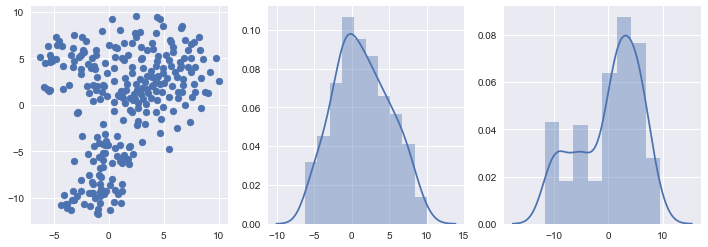

In [5]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(131)
ax.scatter(X[:,0],X[:,1])
ax = fig.add_subplot(132)
sns.distplot(X[:,0])
ax = fig.add_subplot(133)
sns.distplot(X[:,1])

In [6]:
# Identify the states (clusters)
max_states = 10
n_features = X.shape[1]

from sklearn import mixture

dpgmm = mixture.BayesianGaussianMixture(
    n_components=max_states, 
    covariance_type='full',
    weight_concentration_prior_type='dirichlet_process',
    covariance_prior=1e0 * np.eye(n_features),
    init_params="random", tol=1e-6, max_iter=10000, n_init=1, 
    verbose=2, verbose_interval=100).fit(X)

Initialization 0
  Iteration 0	 time lapse 0.00931s	 ll change inf
  Iteration 100	 time lapse 0.25556s	 ll change 0.00443
Initialization converged: True	 time lapse 0.39574s	 ll -1021.93164


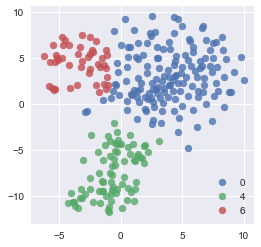

In [7]:
state_assignment = dpgmm.predict(X)
states = np.unique(state_assignment)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
for state in states:
    mask = state_assignment==state
    Xs = X[mask]
    ax.scatter(Xs[:,0], Xs[:,1], alpha=0.8, label=state)
    
plt.legend()

In [8]:
# Construct the state-time data frame
df_state = pd.DataFrame(
    data={'Time': df_copyNumber.index.get_level_values(level=1),
          'State': state_assignment
         })

col_dim = []
for i in range(d):
    df_state['Dim_'+str(i+1)] = X[:,i]
    col_dim.append('Dim_'+str(i+1))

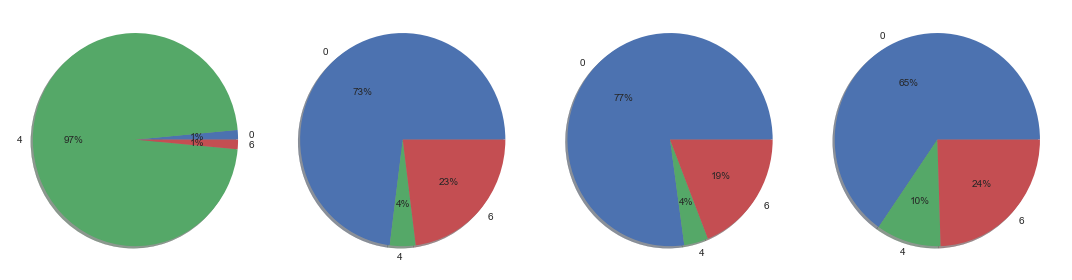

In [9]:
times = time_stamp.unique()

fig = plt.figure(figsize=(5*states.shape[0],4))
for i, time in enumerate(times):
    mask = df_state['Time']==time
    state_dist = df_state[mask]['State'].values
    
    state_freq = []
    for state in states:
        state_freq.append((state_dist[state_dist==state]).shape[0])
    
    ax = fig.add_subplot(1, times.shape[0],i+1)
    #ax.hist(state_dist)
    #ax.set_ylim([0,70])
    ax.pie(state_freq, autopct='%.0f%%', labels=states, shadow=True)
    #ax.set_xticks(states)
    
plt.tight_layout()

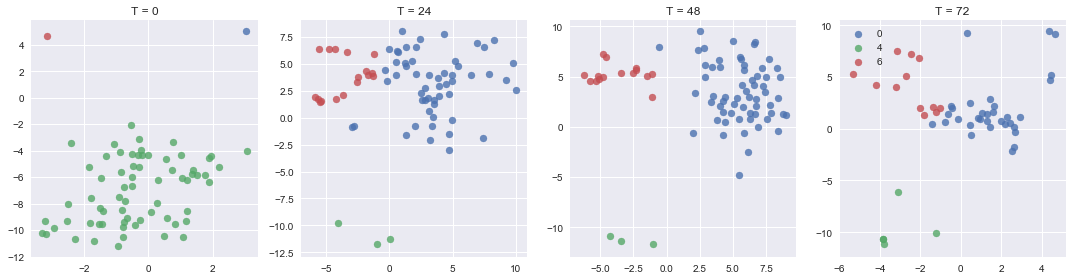

In [10]:
fig = plt.figure(figsize=(5*states.shape[0],4))
for i, time in enumerate(times):
    ax = fig.add_subplot(1, times.shape[0],i+1)
    for state in states:
        mask = (state_assignment==state) & (df_state['Time']==time)
        data = df_state[mask][col_dim]
        ax.scatter(data.iloc[:,0], data.iloc[:,1], alpha=.8, label=state)
        ax.set_title('T = '+str(time))

plt.legend()
plt.tight_layout()